In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import gaussian_kde
import plotly.colors
from plotly.colors import qualitative
from pandas.tseries.offsets import BDay
import torch
import ast
import re

In [123]:
sf = pd.read_csv('SF.csv')
sf.rename(columns={'SCR': 'SF'}, inplace=True)
sf.rename(columns={'Realized_Delta_BOF': 'Realized Delta BOF'}, inplace=True)
sf = sf.reset_index().rename(columns={'index': 'Window'})
sf.head()

,Window,SF,Realized Delta BOF
0,0,"-131,390.78","140,624.03"
1,1,"-128,660.25","148,740.89"
2,2,"-127,960.58","146,156.79"
3,3,"-126,453.05","143,472.76"
4,4,"-126,541.43","140,659.07"


In [124]:
esg = pd.read_csv('ESG Clayton.csv')
esg = esg.reset_index().rename(columns={'index': 'Window'})
esg.rename(columns={'SCR_Values': 'ESG'}, inplace=True)
esg.drop(columns=['Realized_Delta_BOF'], inplace=True, errors='ignore')

esg.head()

,Window,ESG
0,0,"-136,256.84"
1,1,"-130,550.01"
2,2,"-134,189.85"
3,3,"-125,930.46"
4,4,"-127,597.88"


In [125]:
portfolio = pd.read_csv('Portfolio.csv')
portfolio = portfolio.reset_index().rename(columns={'index': 'window'})
portfolio.rename(columns={'scr_values': 'CGAN'}, inplace=True)
portfolio.drop(columns=['realized_delta_bof'], inplace=True, errors='ignore')

portfolio.head()

,window,CGAN
0,0,"-158,455.75"
1,1,"-151,123.93"
2,2,"-146,851.24"
3,3,"-142,511.13"
4,4,"-140,014.46"


In [126]:
plot_df = pd.merge(
    sf[['Window', 'SF', 'Realized Delta BOF']],
    esg[['Window', 'ESG']],
    on='Window',
    how='inner',
)

plot_df = pd.merge(
    plot_df,
    portfolio[['window', 'CGAN']],
    left_on='Window',
    right_on='window',
    how='inner'
).drop(columns=['window'])

plot_df.head()

,Window,SF,Realized Delta BOF,ESG,CGAN
0,0,"-131,390.78","140,624.03","-136,256.84","-158,455.75"
1,1,"-128,660.25","148,740.89","-130,550.01","-151,123.93"
2,2,"-127,960.58","146,156.79","-134,189.85","-146,851.24"
3,3,"-126,453.05","143,472.76","-125,930.46","-142,511.13"
4,4,"-126,541.43","140,659.07","-127,597.88","-140,014.46"


In [127]:
# Divide all entries in the columns 'SF', 'ESG' and 'Realized Delta BOF' by 1000000

plot_df['SF'] = (plot_df['SF'] / 120000) * 100
plot_df['ESG'] = (plot_df['ESG'] / 120000) * 100
plot_df['CGAN'] = (plot_df['CGAN'] / 120000) * 100
plot_df['Realized Delta BOF'] = (plot_df['Realized Delta BOF'] / 120000) * 100

plot_df.head()

,Window,SF,Realized Delta BOF,ESG,CGAN
0,0,-109.49,117.19,-113.55,-132.05
1,1,-107.22,123.95,-108.79,-125.94
2,2,-106.63,121.80,-111.82,-122.38
3,3,-105.38,119.56,-104.94,-118.76
4,4,-105.45,117.22,-106.33,-116.68


# VaR Testing

In [128]:
def plot_var_comparison(df, window_col='Window', realized_col='Realized Delta BOF',
                        sf_col='SF', esg_col='ESG', cgan_col='CGAN'):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    plt.plot(df[window_col], df[realized_col], label='Realized $\Delta$BOF',
             color='black', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[sf_col], label='SF (VaR Forecasted)',
             color='darkorange', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[esg_col], label='ESG (VaR Forecasted)',
             color='forestgreen', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[cgan_col], label='cGAN (VaR Forecasted)',
            color='royalblue', linestyle='--', linewidth=1.5)

    plt.xlabel('Window', fontsize=18)
    plt.ylabel(
        'Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)

    legend = plt.legend(fontsize=15, frameon=False, fancybox=True,
                        shadow=True, framealpha=0.95, loc='best')
    legend.get_frame().set_edgecolor('black')

    plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    plt.tight_layout()
    plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1575944701.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(df[window_col], df[realized_col], label='Realized $\Delta$BOF',
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1575944701.py:17: SyntaxWarning: invalid escape sequence '\D'
  'Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)


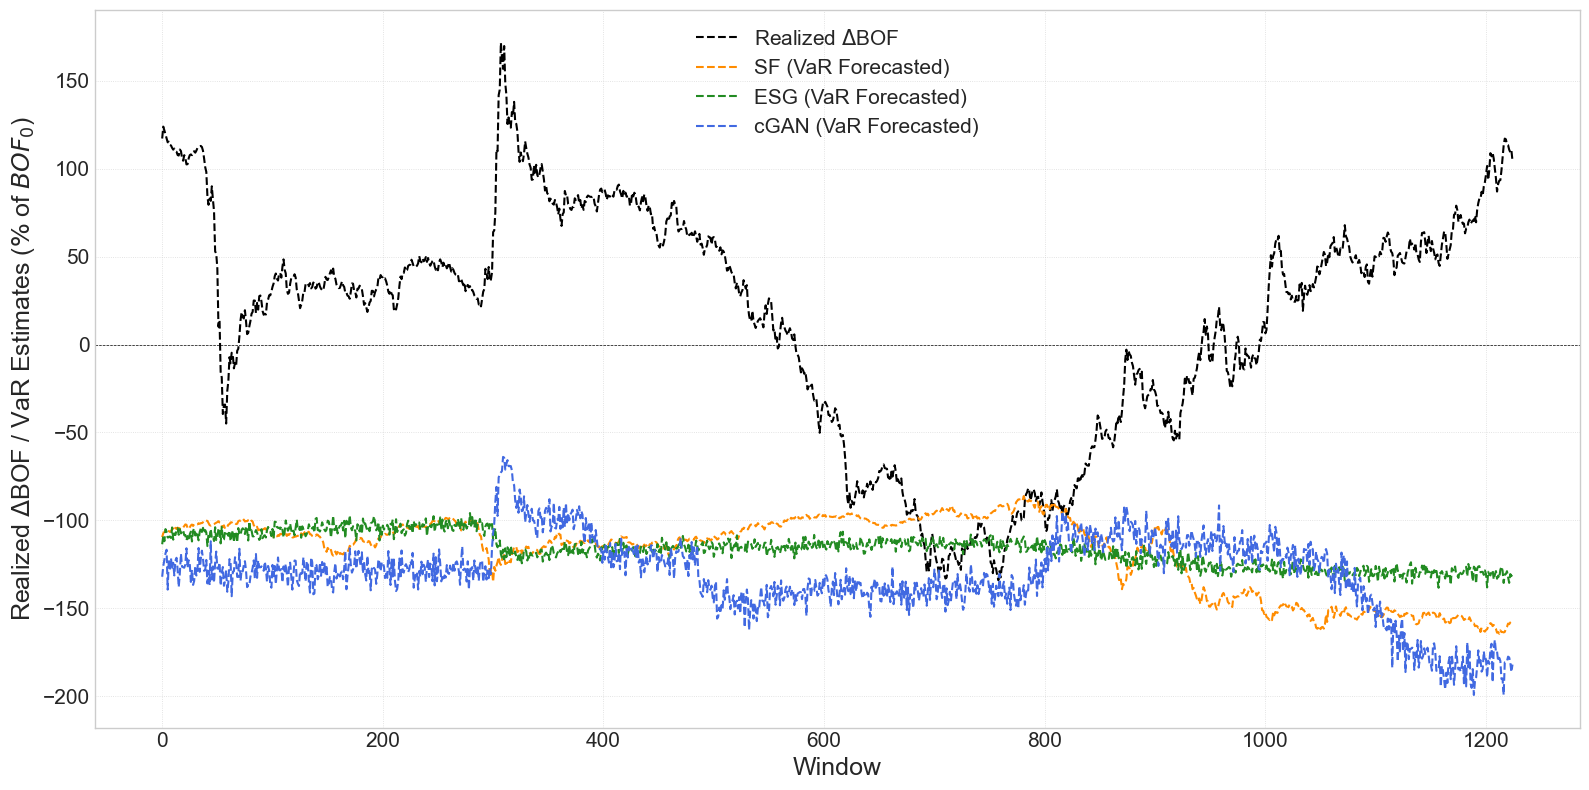

In [129]:
plot_var_comparison(plot_df)

In [130]:
import sys
sys.path.append('..')
from backtesting.perform_var_tests import evaluate_risk_metrics

In [131]:
evaluate_risk_metrics(scr_values=plot_df['SF'],  realized_delta_bof_values=plot_df['Realized Delta BOF'])

breaches [0 0 0 ... 0 0 0]


,Metric,Value,Description,Pass/Fail
0,Balanced SCR Loss (α=0.25),33.7794,Penalty for under-conservatism,
1,Balanced SCR Loss (α=0.5),67.5541,Penalty for balanced,
2,Balanced SCR Loss (α=0.75),101.3287,Penalty for capital inefficiency,
3,Kupiec POF Test Statistic,418.9751,Kupiec test statistic,
4,Kupiec POF Test p-value,0.0000,Tests if breach frequency matches expected,❌
5,Indep. Test Statistic,621.4262,Independence test statistic,
6,Indep. Test p-value,0.0000,Tests if breaches are independent,❌
7,Cond. Coverage Statistic,1040.4013,Conditional coverage test statistic,
8,Cond. Coverage p-value,0.0000,Combined test of frequency and independence,❌
9,Lopez Average Loss,0.0920,Quadratic loss function for VaR breaches,


In [132]:
evaluate_risk_metrics(scr_values=plot_df['ESG'],  realized_delta_bof_values=plot_df['Realized Delta BOF'])

breaches [0 0 0 ... 0 0 0]


,Metric,Value,Description,Pass/Fail
0,Balanced SCR Loss (α=0.25),32.8973,Penalty for under-conservatism,
1,Balanced SCR Loss (α=0.5),65.7942,Penalty for balanced,
2,Balanced SCR Loss (α=0.75),98.6911,Penalty for capital inefficiency,
3,Kupiec POF Test Statistic,136.8151,Kupiec test statistic,
4,Kupiec POF Test p-value,0.0000,Tests if breach frequency matches expected,❌
5,Indep. Test Statistic,323.7761,Independence test statistic,
6,Indep. Test p-value,0.0000,Tests if breaches are independent,❌
7,Cond. Coverage Statistic,460.5911,Conditional coverage test statistic,
8,Cond. Coverage p-value,0.0000,Combined test of frequency and independence,❌
9,Lopez Average Loss,0.0437,Quadratic loss function for VaR breaches,


In [133]:
len(plot_df['Realized Delta BOF']) * 0.0016

1.9600000000000002

In [134]:
evaluate_risk_metrics(scr_values=plot_df['CGAN'],  realized_delta_bof_values=plot_df['Realized Delta BOF'])

breaches [0 0 0 ... 0 0 0]


,Metric,Value,Description,Pass/Fail
0,Balanced SCR Loss (α=0.25),36.1936,Penalty for under-conservatism,
1,Balanced SCR Loss (α=0.5),72.3872,Penalty for balanced,
2,Balanced SCR Loss (α=0.75),108.5808,Penalty for capital inefficiency,
3,Kupiec POF Test Statistic,3.7870,Kupiec test statistic,
4,Kupiec POF Test p-value,0.0517,Tests if breach frequency matches expected,✅
5,Indep. Test Statistic,0.0065,Independence test statistic,
6,Indep. Test p-value,0.9355,Tests if breaches are independent,✅
7,Cond. Coverage Statistic,3.7936,Conditional coverage test statistic,
8,Cond. Coverage p-value,0.1501,Combined test of frequency and independence,✅
9,Lopez Average Loss,0.0016,Quadratic loss function for VaR breaches,


# Responsiveness to Market Conditions

In [135]:
first1yr_realized_delta_bof = pd.read_csv('First 1yr - Realized Delta BOF.csv')
first1yr_realized_delta_bof['Realized_Delta_BOF'] = (first1yr_realized_delta_bof['Realized_Delta_BOF'] / 120000) * 100
first1yr_realized_delta_bof.head()

,Realized_Delta_BOF
0,-12.48
1,-17.08
2,-12.79
3,-9.96
4,-6.26


In [136]:
first1yr_realized_delta_bof.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Realized_Delta_BOF  251 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [137]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Window              1225 non-null   int64  
 1   SF                  1225 non-null   float64
 2   Realized Delta BOF  1225 non-null   float64
 3   ESG                 1225 non-null   float64
 4   CGAN                1225 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 48.0 KB


<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1329727827.py:7: SyntaxWarning: invalid escape sequence '\D'
  label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1329727827.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1329727827.py:36: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(first1yr_window, first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


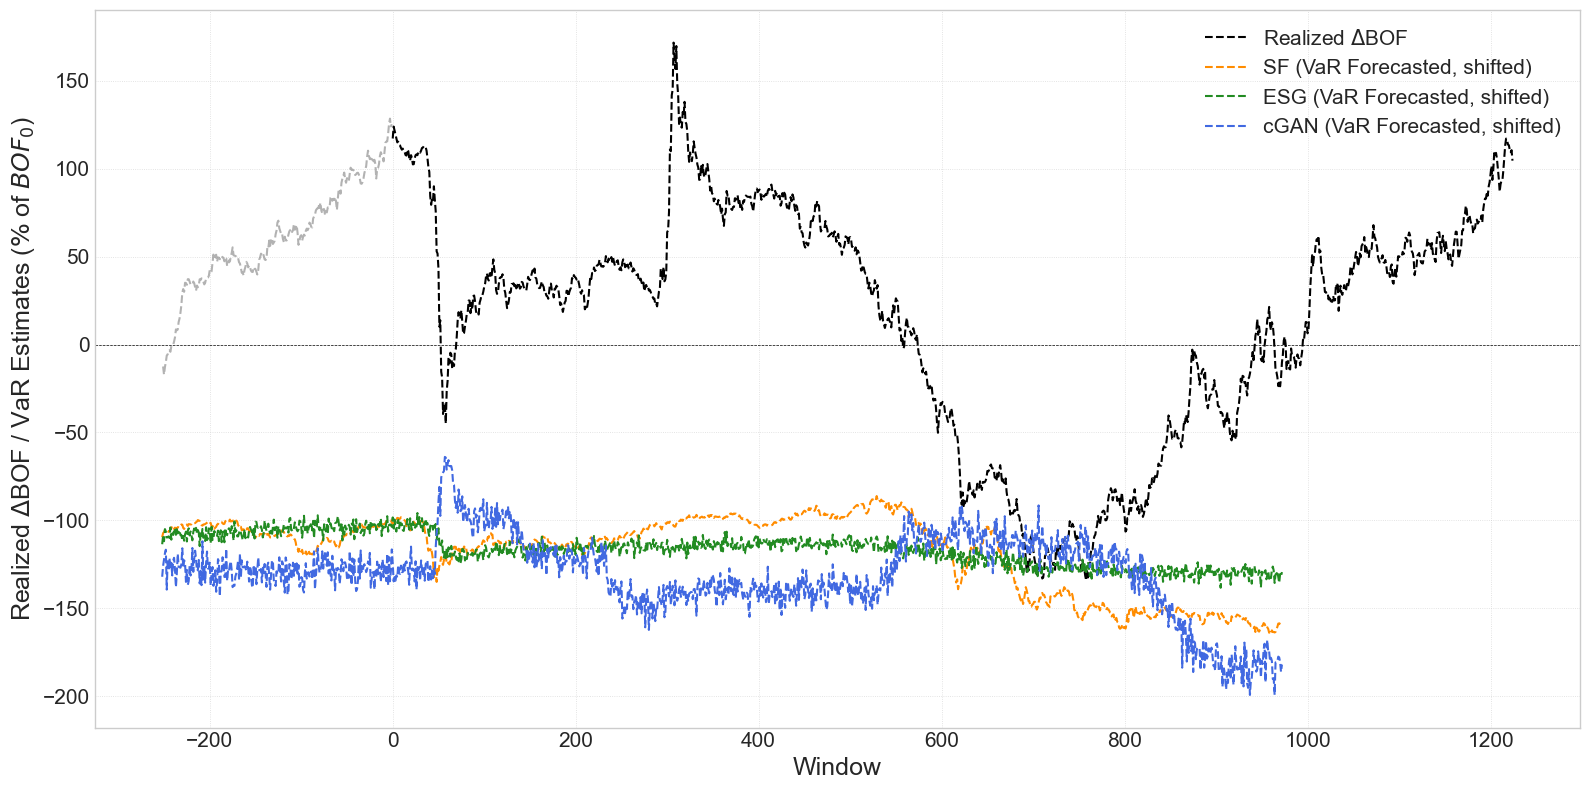

In [138]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(16, 8))

# Plot Realized Delta BOF
plt.plot(plot_df['Window'], plot_df['Realized Delta BOF'],
         label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)

# Plot SF and ESG with both values and x shifted
plt.plot(plot_df['Window'] - 252, plot_df['SF'],
         label='SF (VaR Forecasted, shifted)', color='darkorange', linestyle='--', linewidth=1.5)
plt.plot(plot_df['Window'] - 252, plot_df['ESG'],
         label='ESG (VaR Forecasted, shifted)', color='forestgreen', linestyle='--', linewidth=1.5)
plt.plot(plot_df['Window'] - 252, plot_df['CGAN'],
         label='cGAN (VaR Forecasted, shifted)', color='royalblue', linestyle='--', linewidth=1.5)

plt.xlabel('Window', fontsize=18)
plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)

legend = plt.legend(fontsize=15, frameon=False, fancybox=True,
                    shadow=True, framealpha=0.95, loc='best')
legend.get_frame().set_edgecolor('black')

plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

plt.tight_layout()

first1yr_window = list(range(-251, 0))  

plt.plot(first1yr_window, first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


plt.show()

First date in grey : 2019-01-01

Last date in grey : 2019-12-31 

First date in black : 2020-01-02

# Average Required Capital 

In [139]:
cum_df = plot_df.filter(items=['Window', 'SF', 'ESG', 'CGAN']).copy()
cum_df['SF'] = (cum_df['SF'] * -1)
cum_df['ESG'] = (cum_df['ESG'] * -1)
cum_df['CGAN'] = (cum_df['CGAN'] * -1)
cum_df.head()

,Window,SF,ESG,CGAN
0,0,109.49,113.55,132.05
1,1,107.22,108.79,125.94
2,2,106.63,111.82,122.38
3,3,105.38,104.94,118.76
4,4,105.45,106.33,116.68


<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\3654640451.py:14: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('SCR ($\%$ of $BOF_0$})', fontsize=18)


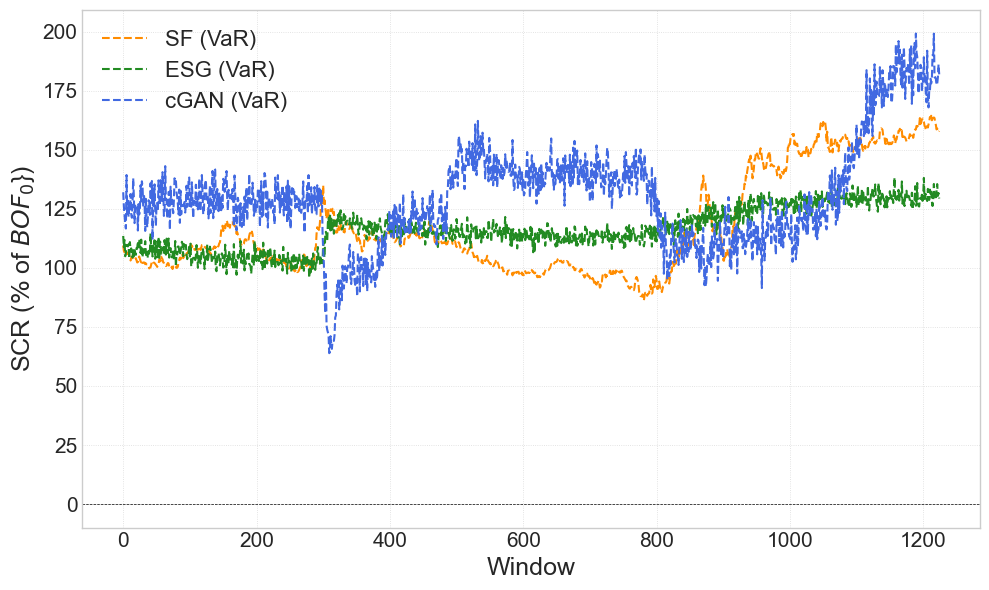

In [140]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(cum_df['Window'], cum_df['SF'], label='SF (VaR)', color='darkorange',
         linestyle='--', linewidth=1.5, marker=None, markersize=3)
plt.plot(cum_df['Window'], cum_df['ESG'], label='ESG (VaR)',
         color='forestgreen', linestyle='--', linewidth=1.5, marker=None, markersize=3)
plt.plot(cum_df['Window'], cum_df['CGAN'], label='cGAN (VaR)',
         color='royalblue', linestyle='--', linewidth=1.5, marker=None, markersize=3)


plt.xlabel('Window', fontsize=18)
plt.ylabel('SCR ($\%$ of $BOF_0$})', fontsize=18)

legend = plt.legend(fontsize=16, frameon=False, fancybox=True,
                    shadow=True, framealpha=0.95, loc='best')
legend.get_frame().set_edgecolor('black')

plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')


plt.tight_layout()

plt.show()

## Integral under plots - Just for fun

In [141]:
import numpy as np

# Calculate area under each curve
sf_integral = np.trapz(cum_df['SF'], cum_df['Window'])
esg_integral = np.trapz(cum_df['ESG'], cum_df['Window'])
cgan_integral = np.trapz(cum_df['CGAN'], cum_df['Window'])

print(f"SF (VaR) integral: {sf_integral:.4f}")
print(f"ESG (VaR) integral: {esg_integral:.4f}")
print(f"cGAN (VaR) integral: {cgan_integral:.4f}")

SF (VaR) integral: 143730.6384
ESG (VaR) integral: 142384.3719
cGAN (VaR) integral: 159527.5130


C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\2511408556.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sf_integral = np.trapz(cum_df['SF'], cum_df['Window'])
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\2511408556.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  esg_integral = np.trapz(cum_df['ESG'], cum_df['Window'])
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\2511408556.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cgan_integral = np.trapz(cum_df['CGAN'], cum_df['Window'])


In [142]:
cum_df.describe()

,Window,SF,ESG,CGAN
count,"1,225.00","1,225.00","1,225.00","1,225.00"
mean,612.00,117.44,116.33,130.35
std,353.77,21.29,8.98,21.95
min,0.00,86.14,95.81,63.89
25%,306.00,101.54,110.11,116.96
50%,612.00,110.01,115.49,128.82
75%,918.00,130.99,123.23,140.52
max,"1,224.00",164.45,138.31,199.27


<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:43: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:43: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\4281805509.py:13: SyntaxWarning: invalid escape sequence '\%'
  ax1.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\4281805509.py:28: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\4281805509.py:43: SyntaxWarning: invalid escape sequence '\%'
  ax3.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\4281805509.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integr

Area under SF distribution: 2940.00


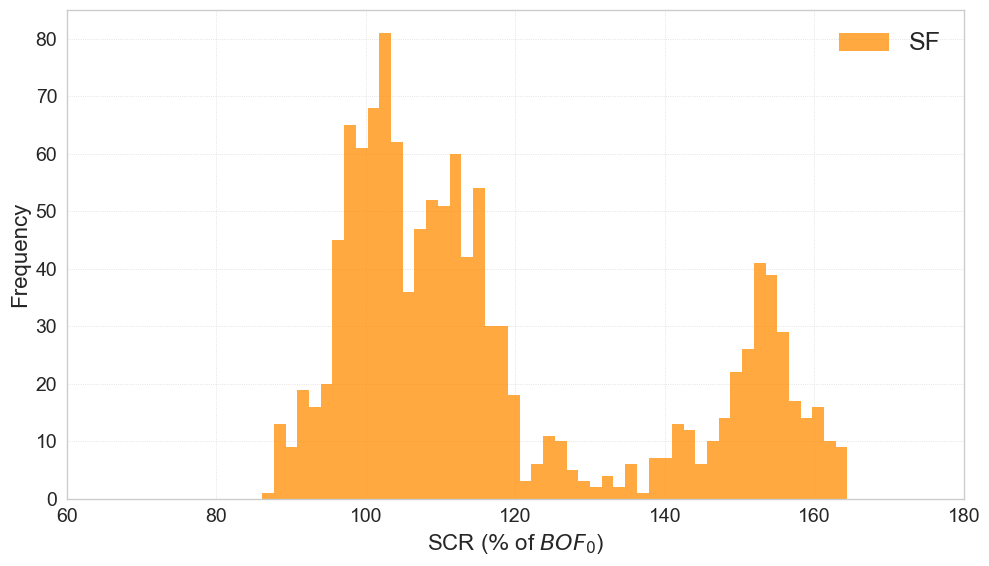

Area under ESG distribution: 2940.00


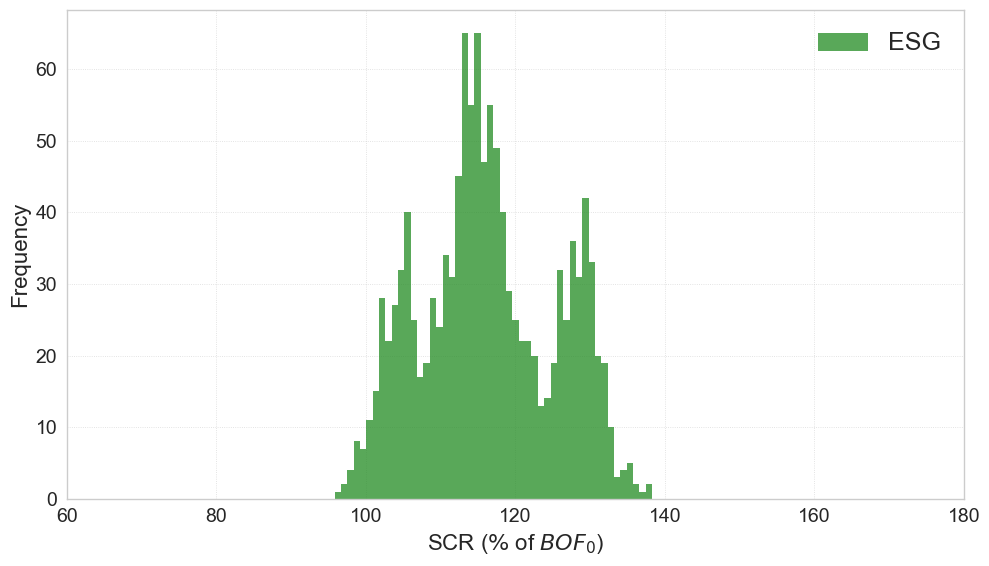

Area under CGAN distribution: 2792.40


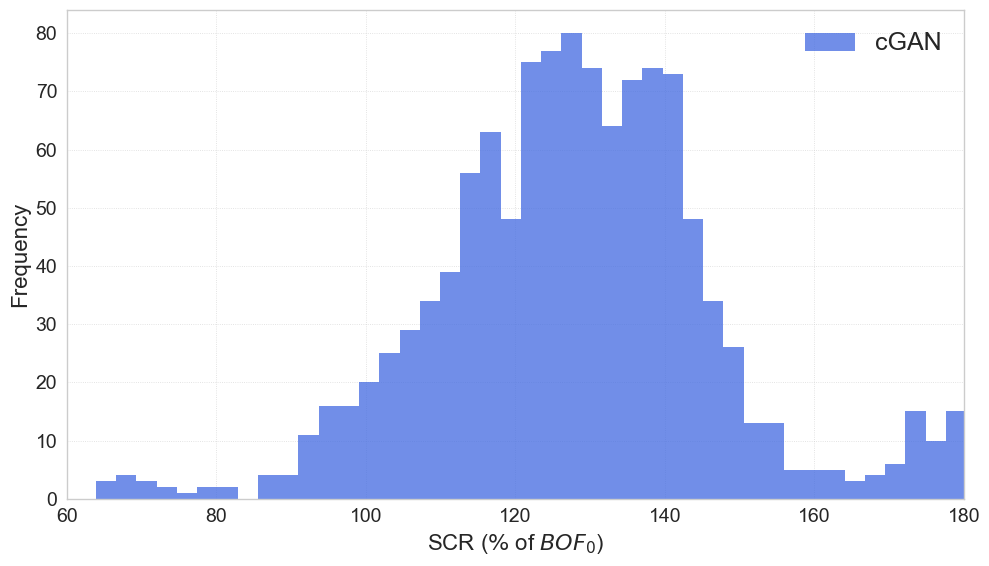

SF area: 2940.00
ESG area: 2940.00
CGAN area: 2792.40


In [143]:
plt.style.use('seaborn-v0_8-whitegrid')

def calculate_area_under_histogram(data, bins=50, x_range=(60, 180)):
    counts, bin_edges = np.histogram(data, bins=bins, range=x_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    area = np.trapz(counts, bin_centers)
    return area, counts, bin_centers

fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(cum_df['SF'], bins=50, color='darkorange', edgecolor=None, alpha=0.75, label='SF')
sf_area, sf_counts, sf_centers = calculate_area_under_histogram(cum_df['SF'])
print(f"Area under SF distribution: {sf_area:.2f}")
ax1.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)
ax1.set_xlim(60, 180)
legend1 = ax1.legend(fontsize=18, frameon=False, fancybox=True, shadow=True, framealpha=0.95, loc='best')
legend1.get_frame().set_edgecolor('black')
ax1.tick_params(axis='both', which='major', labelsize=14, pad=7)
ax1.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.hist(cum_df['ESG'], bins=50, color='forestgreen', edgecolor=None, alpha=0.75, label='ESG')
esg_area, esg_counts, esg_centers = calculate_area_under_histogram(cum_df['ESG'])
print(f"Area under ESG distribution: {esg_area:.2f}")
ax2.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)
ax2.set_xlim(60, 180)
legend2 = ax2.legend(fontsize=18, frameon=False, fancybox=True, shadow=True, framealpha=0.95, loc='best')
legend2.get_frame().set_edgecolor('black')
ax2.tick_params(axis='both', which='major', labelsize=14, pad=7)
ax2.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax2.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.hist(cum_df['CGAN'], bins=50, color='royalblue', edgecolor=None, alpha=0.75, label='cGAN')
cgan_area, cgan_counts, cgan_centers = calculate_area_under_histogram(cum_df['CGAN'])
print(f"Area under CGAN distribution: {cgan_area:.2f}")
ax3.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
ax3.set_ylabel('Frequency', fontsize=16)
ax3.set_xlim(60, 180)
legend3 = ax3.legend(fontsize=18, frameon=False, fancybox=True, shadow=True, framealpha=0.95, loc='best')
legend3.get_frame().set_edgecolor('black')
ax3.tick_params(axis='both', which='major', labelsize=14, pad=7)
ax3.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax3.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"SF area: {sf_area:.2f}")
print(f"ESG area: {esg_area:.2f}")
print(f"CGAN area: {cgan_area:.2f}")

<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\24593765.py:12: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16, labelpad=10)


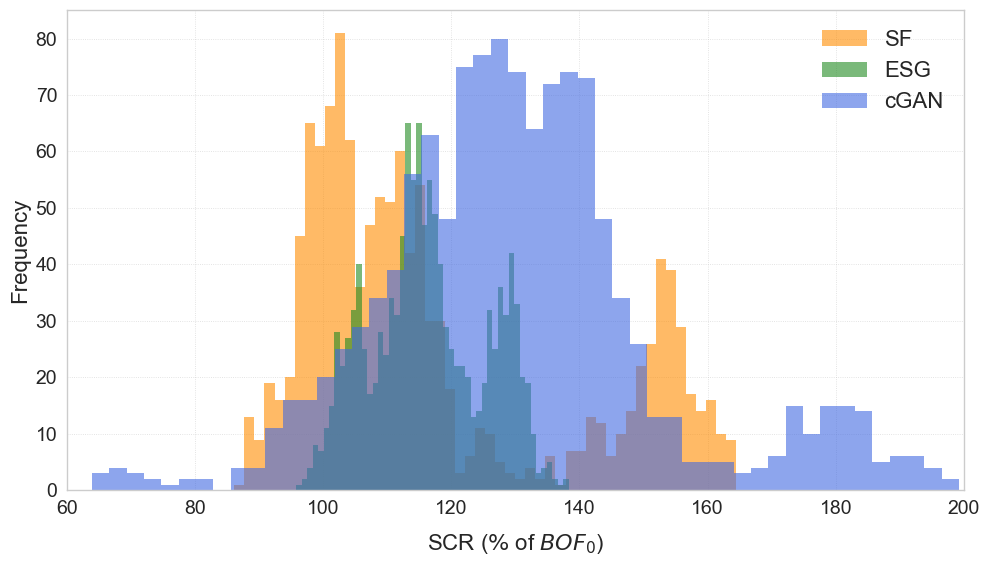

In [144]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(cum_df['SF'], bins=50, color='darkorange',
        alpha=0.6, label='SF', edgecolor=None)
ax.hist(cum_df['ESG'], bins=50, color='forestgreen',
        alpha=0.6, label='ESG', edgecolor=None)
ax.hist(cum_df['CGAN'], bins=50, color='royalblue',
        alpha=0.6, label='cGAN', edgecolor=None)

ax.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16, labelpad=10)
ax.set_ylabel('Frequency', fontsize=16)

ax.set_xlim(60, 200)

legend = ax.legend(fontsize=16, frameon=False, fancybox=True,
                   shadow=True, framealpha=0.95, loc='best')
legend.get_frame().set_edgecolor('black')

ax.tick_params(axis='both', which='major', labelsize=14, pad=7)

ax.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [145]:
sf_count = len(cum_df['SF'].dropna())
esg_count = len(cum_df['ESG'].dropna())
cgan_count = len(cum_df['CGAN'].dropna())

print("Sample sizes:")
print(f"SF:   {sf_count:,}")
print(f"ESG:  {esg_count:,}")
print(f"cGAN: {cgan_count:,}")

# Check if any are different
if len(set([sf_count, esg_count, cgan_count])) > 1:
    print("\n⚠️  Sample sizes are NOT equal!")
    max_count = max(sf_count, esg_count, cgan_count)
    min_count = min(sf_count, esg_count, cgan_count)
    print(f"Difference: {max_count - min_count:,} samples")
else:
    print("\n✓ All sample sizes are equal")

# Check for missing values
print(f"\nMissing values:")
print(f"SF:   {cum_df['SF'].isna().sum()}")
print(f"ESG:  {cum_df['ESG'].isna().sum()}")
print(f"cGAN: {cum_df['CGAN'].isna().sum()}")

# Check data range coverage within your plot limits (60-180)
sf_in_range = ((cum_df['SF'] >= 60) & (cum_df['SF'] <= 180)).sum()
esg_in_range = ((cum_df['ESG'] >= 60) & (cum_df['ESG'] <= 180)).sum()
cgan_in_range = ((cum_df['CGAN'] >= 60) & (cum_df['CGAN'] <= 180)).sum()

print(f"\nData points within plot range (60-180):")
print(f"SF:   {sf_in_range:,}")
print(f"ESG:  {esg_in_range:,}")
print(f"cGAN: {cgan_in_range:,}")

Sample sizes:
SF:   1,225
ESG:  1,225
cGAN: 1,225

✓ All sample sizes are equal

Missing values:
SF:   0
ESG:  0
cGAN: 0

Data points within plot range (60-180):
SF:   1,225
ESG:  1,225
cGAN: 1,169


# VaR testing \ capital efficiency per GAN-type

In [146]:
asset_classes = pd.read_csv('../data/final_asset_classes.csv', index_col=0, parse_dates=True)
asset_classes.columns = ['RE', 'PE', 'EQ', 'IG CB', 'GB', 'HY CB', 'Money']
asset_classes = asset_classes[['EQ', 'PE','RE', 'IG CB', 'HY CB', 'GB', 'Money']]
asset_classes.head()

,EQ,PE,RE,IG CB,HY CB,GB,Money
Date,,,,,,,
2005-10-10,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2005-10-11,1.00,1.01,1.00,1.00,1.00,1.00,1.00
2005-10-12,1.00,1.00,1.00,1.00,0.99,1.00,1.00
2005-10-13,1.00,0.99,0.98,0.99,0.99,0.99,1.00
2005-10-14,0.99,0.99,0.97,0.99,0.99,0.99,1.00


In [147]:
asset_classes.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4891 entries, 2005-10-10 to 2024-11-13
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EQ      4890 non-null   float64
 1   PE      4874 non-null   float64
 2   RE      4870 non-null   float64
 3   IG CB   4810 non-null   float64
 4   HY CB   4810 non-null   float64
 5   GB      4879 non-null   float64
 6   Money   4891 non-null   float64
dtypes: float64(7)
memory usage: 305.7 KB


<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\806828781.py:25: SyntaxWarning: invalid escape sequence '\D'
  ax1.plot(plot_df['Window'], plot_df['Realized Delta BOF'], label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\806828781.py:31: SyntaxWarning: invalid escape sequence '\D'
  ax1.plot(range(-251, 0), first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\806828781.py:35: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel('Realized $\Delta$BOF / VaR Estimates 

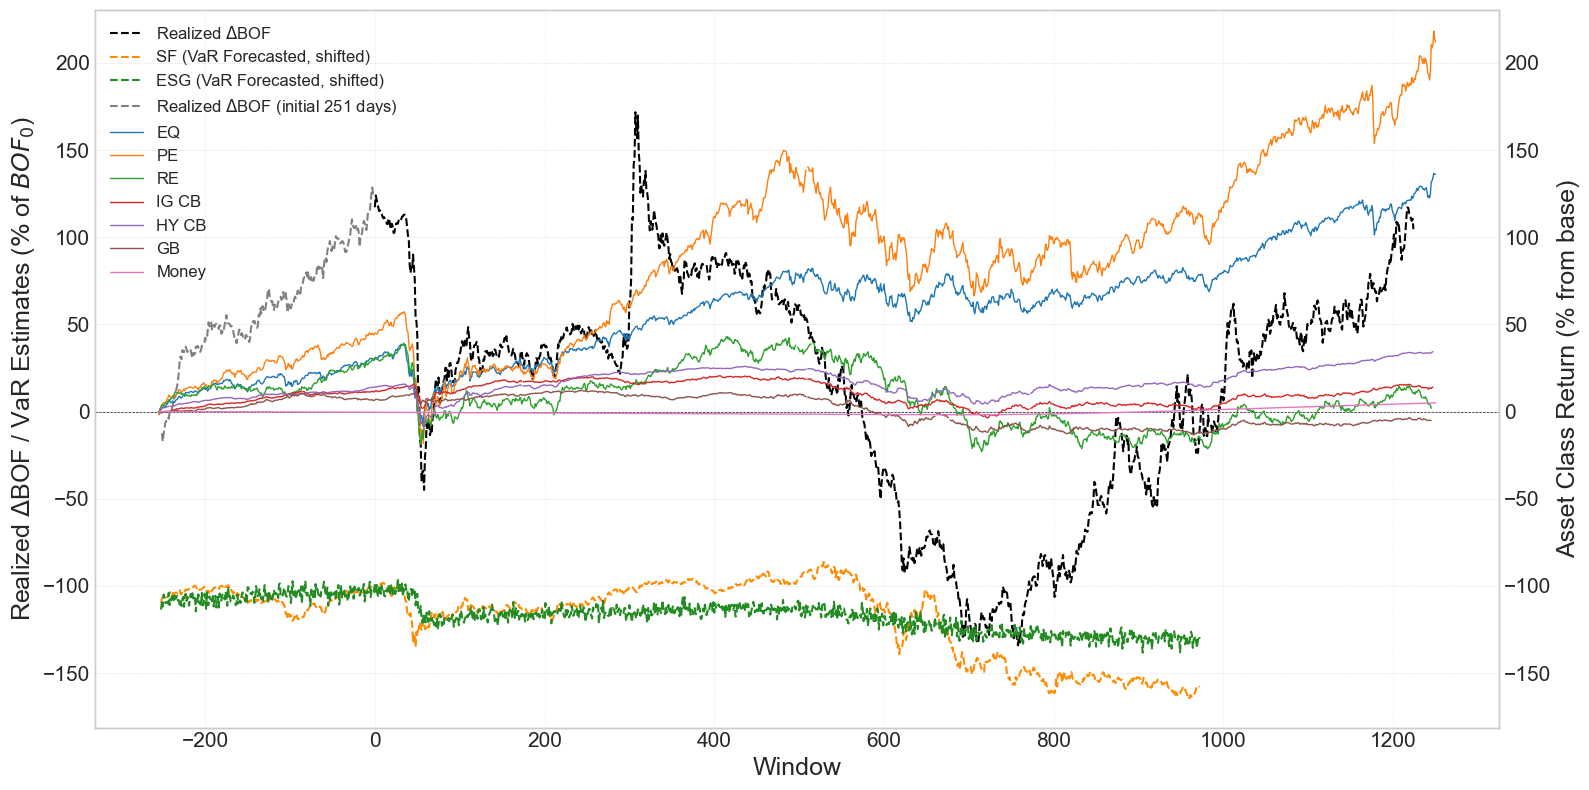

In [148]:
first1yr_start_date = pd.to_datetime('2019-01-01')
first1yr_end_date = pd.to_datetime('2019-12-31')
main_bof_start_date = pd.to_datetime('2020-01-02')
main_bof_end_date = pd.to_datetime('2024-11-13')

first1yr_slice = asset_classes.loc[first1yr_start_date:first1yr_end_date].copy()
main_bof_slice = asset_classes.loc[main_bof_start_date:main_bof_end_date].copy()

first1yr_slice['Window'] = range(-len(first1yr_slice), 0)
main_bof_slice['Window'] = range(0, len(main_bof_slice))
asset_window_df = pd.concat([first1yr_slice, main_bof_slice])

asset_pct = asset_window_df.drop(columns='Window').div(
    asset_window_df.drop(columns='Window').iloc[0]).subtract(1).multiply(100)


asset_pct['Window'] = asset_window_df['Window'].values


plt.style.use('seaborn-v0_8-whitegrid')

fig, ax1 = plt.subplots(figsize=(16, 8))


ax1.plot(plot_df['Window'], plot_df['Realized Delta BOF'], label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5)

ax1.plot(plot_df['Window'] - 252, plot_df['SF'], label='SF (VaR Forecasted, shifted)', color='darkorange', linestyle='--', linewidth=1.5)

ax1.plot(plot_df['Window'] - 252, plot_df['ESG'], label='ESG (VaR Forecasted, shifted)', color='forestgreen', linestyle='--', linewidth=1.5)

ax1.plot(range(-251, 0), first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5)

ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax1.set_xlabel('Window', fontsize=18)
ax1.set_ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)
ax1.tick_params(axis='both', labelsize=15)


ax2 = ax1.twinx()

for col in ['EQ', 'PE', 'RE', 'IG CB', 'HY CB', 'GB', 'Money']:
    ax2.plot(asset_pct['Window'], asset_pct[col], label=col, linewidth=1)

ax2.set_ylabel('Asset Class Return (% from base)', fontsize=18)
ax2.tick_params(axis='y', labelsize=15)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12, loc='upper left',frameon=False, fancybox=True, shadow=True, framealpha=0.95)


y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()

y1_range_below = abs(y1_min)
y1_range_above = abs(y1_max)
y2_range_below = abs(y2_min)
y2_range_above = abs(y2_max)

below = max(y1_range_below, y2_range_below)
above = max(y1_range_above, y2_range_above)

ax1.set_ylim(-below, above)
ax2.set_ylim(-below, above)
ax1.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.5)
ax2.grid(True, which='major', linestyle=':', linewidth=0.4, alpha=0.5)


plt.tight_layout()
plt.show()

# Plotting Forecasted vs realised VaR for all assets 

### dealing with a gay data format

In [149]:
def _fully_flatten_cell_content(content) -> list:
    if isinstance(content, str):
        tensor_match = re.match(r"tensor\(([^,]+),.*\)", content)
        if tensor_match:
            try:
                numeric_value = float(tensor_match.group(1))
                return [numeric_value]
            except (ValueError, TypeError):
                pass

        try:
            evaluated_content = ast.literal_eval(content)
            if evaluated_content == content and not tensor_match:
                return [content]
            return _fully_flatten_cell_content(evaluated_content)
        except (ValueError, SyntaxError):
            return [content]
    elif isinstance(content, (list, tuple)):
        items = []
        for item in content:
            items.extend(_fully_flatten_cell_content(item))
        return items
    else:
        return [content]


def unpack_and_explode_column(df: pd.DataFrame, column_to_unpack: str) -> pd.DataFrame:
    if column_to_unpack not in df.columns:
        raise ValueError(
            f"DataFrame must contain a '{column_to_unpack}' column.")

    processed_series = df[column_to_unpack].apply(_fully_flatten_cell_content)

    new_df = df.copy()

    new_df[column_to_unpack] = processed_series

    return new_df.explode(column_to_unpack)

In [150]:
def plot_single_forecast(df, window_col, realized_col, var_col, label='VaR Forecast'):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    plt.plot(df[window_col], df[realized_col], label='Realized Return',
             color='black', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[var_col], label=label,
             color='blue', linestyle='--', linewidth=1.5)

    plt.xlabel('Window', fontsize=18)
    plt.ylabel(
        'Realized Return / VaR Estimate ($\%$)', fontsize=18)
    
    plt.ylim(-70, 110)

    legend = plt.legend(fontsize=18, frameon=False, fancybox=True,
                        shadow=True, framealpha=0.95, loc='best')
    legend.get_frame().set_edgecolor('black')

    plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    plt.tight_layout()
    plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\3604140044.py:12: SyntaxWarning: invalid escape sequence '\%'
  'Realized Return / VaR Estimate ($\%$)', fontsize=18)


### EQ

In [151]:
eq = pd.read_csv('EQ.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
eq = unpack_and_explode_column(eq, 'SCR')
eq.rename(columns={'SCR': 'EQ VaR (utcome-aligned)'}, inplace=True)
eq.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
eq = eq.reset_index().rename(columns={'index': 'Window'})
eq['EQ VaR (utcome-aligned)'] = ((eq['EQ VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
eq['Realised Return'] = ((eq['Realised Return'] - 1000000) / 1000000) * 100
eq.head()

,Window,EQ VaR (utcome-aligned),Realised Return
0,0,-14.40,30.64
1,1,-13.66,34.32
2,2,-13.94,30.64
3,3,-14.13,29.97
4,4,-14.63,29.11


In [152]:
def plot_shifted(shifted, df1, df2, name, col):
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(12, 8))

    # Plot Realized Delta BOF
    plt.plot(df1['Window'], df1['Realised Return'],
            label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)

    # Plot SF and ESG with both values and x shifted
    plt.plot(df2['Window'] - 252, df2[col],
            label=f'{name} (VaR Forecasted, shifted)', color='blue', linestyle='--', linewidth=1.5)
    plt.xlabel('Window', fontsize=18)
    plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)

    legend = plt.legend(fontsize=18, frameon=False, fancybox=True,
                        shadow=True, framealpha=0.95, loc='best')
    legend.get_frame().set_edgecolor('black')

    plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.ylim(-70, 110)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    plt.tight_layout()

    first1yr_window = list(range(-252, 0))  

    plt.plot(first1yr_window, shifted, label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


    plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1910967926.py:8: SyntaxWarning: invalid escape sequence '\D'
  label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1910967926.py:14: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)
C:\Users\nicka\AppData\Local\Temp\ipykernel_1520\1910967926.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(first1yr_window, shifted, label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


In [153]:
shifted = pd.read_csv('shifted_part_all_assets.csv')
shifted.head()
shifted = ((shifted - 1000000) / 1000000) * 100
#shifted.head()

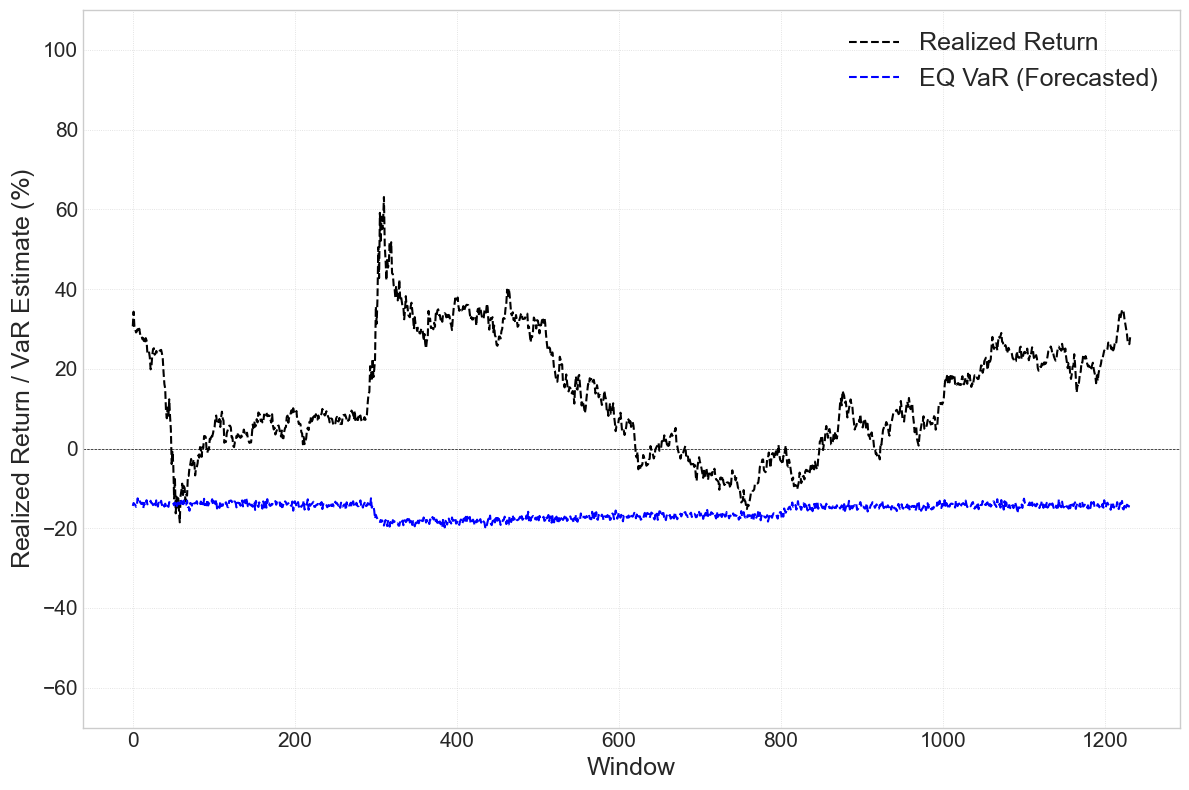

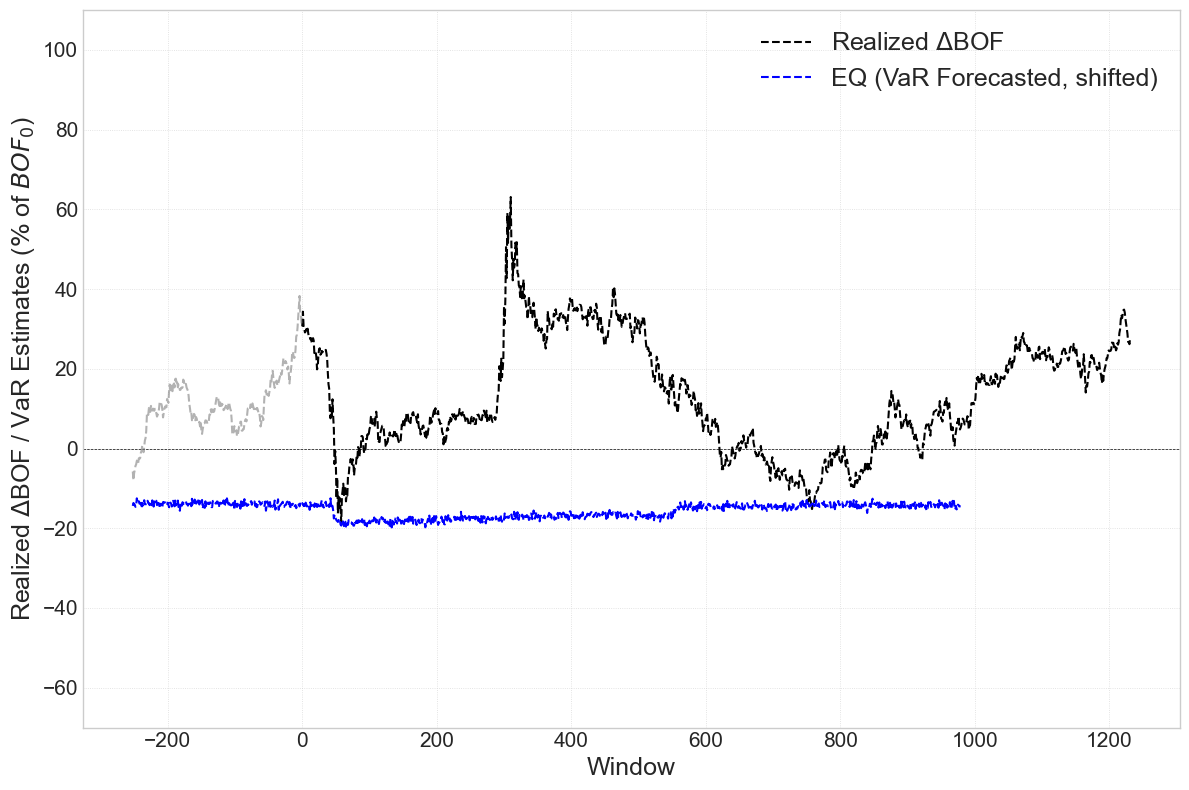

In [154]:
plot_single_forecast(
    df=eq,
    window_col='Window',
    realized_col='Realised Return',
    var_col='EQ VaR (utcome-aligned)',  
    label='EQ VaR (Forecasted)'         
)

plot_shifted(
    shifted['EQ'],
    df1=eq,
    df2=eq,
    name='EQ',
    col='EQ VaR (utcome-aligned)',  
)

### PE

In [155]:
pe = pd.read_csv('PE.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
pe = unpack_and_explode_column(pe, 'SCR')
pe.rename(columns={'SCR': 'PE VaR (utcome-aligned)'}, inplace=True)
pe.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
pe = pe.reset_index().rename(columns={'index': 'Window'})
pe['PE VaR (utcome-aligned)'] = ((pe['PE VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
pe['Realised Return'] = ((pe['Realised Return'] - 1000000) / 1000000) * 100
pe.head()

,Window,PE VaR (utcome-aligned),Realised Return
0,0,-24.71,45.66
1,1,-25.86,49.12
2,2,-25.49,44.76
3,3,-23.74,41.95
4,4,-24.34,40.61


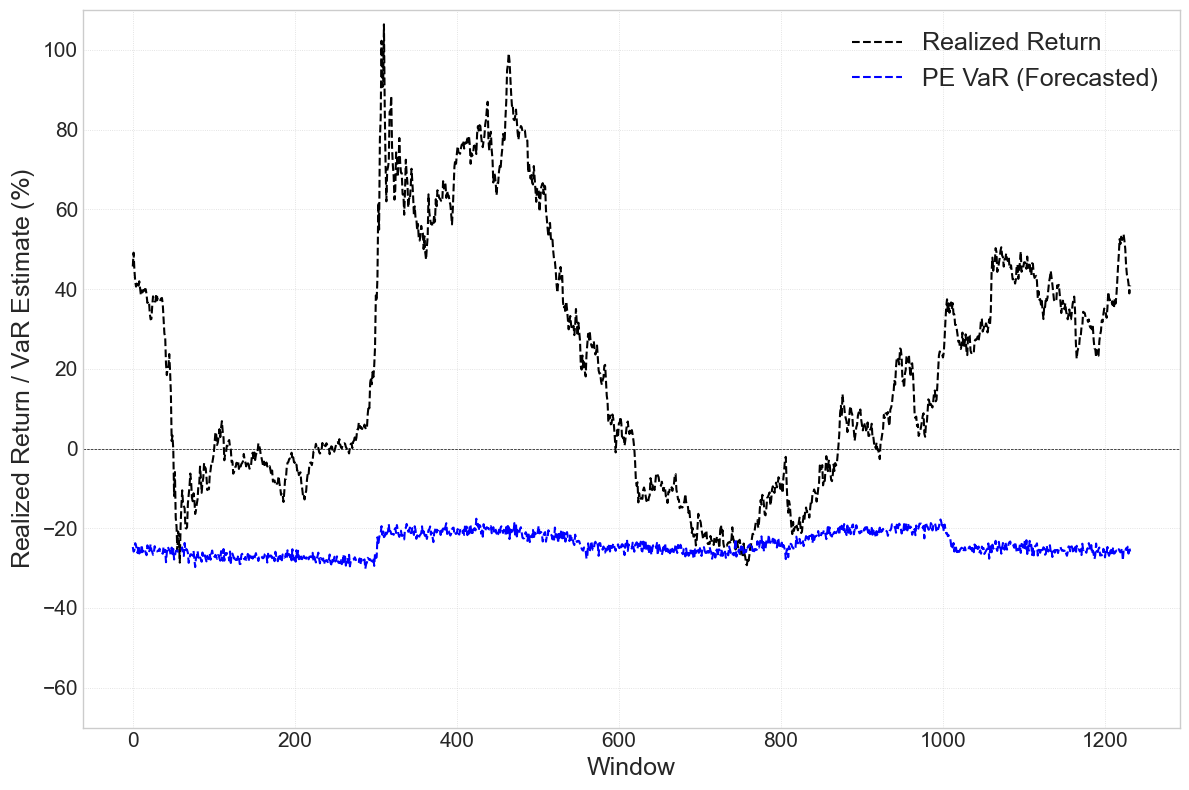

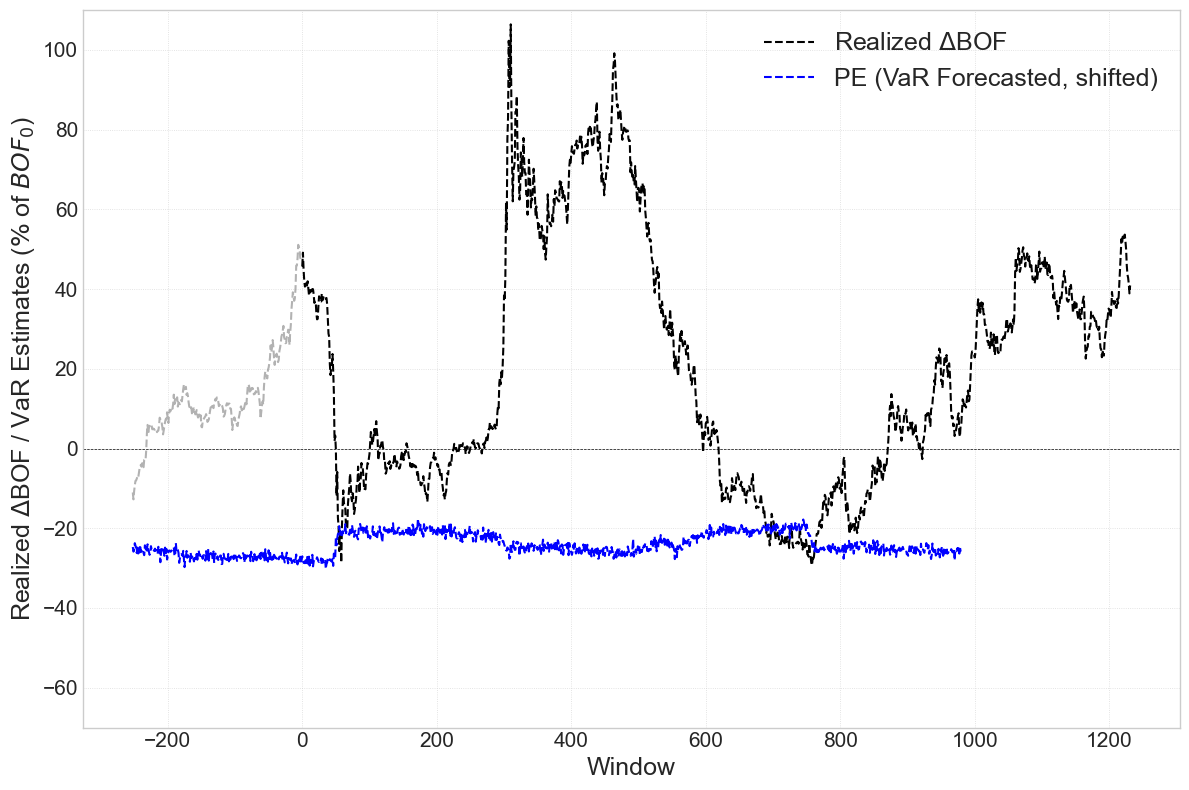

In [156]:
plot_single_forecast(
    df=pe,
    window_col='Window',
    realized_col='Realised Return',
    var_col='PE VaR (utcome-aligned)',
    label='PE VaR (Forecasted)'
)

plot_shifted(
    shifted['PE'],
    df1=pe,
    df2=pe,
    name='PE',
    col='PE VaR (utcome-aligned)',  
)

### RE

In [157]:
reel = pd.read_csv('RE.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
reel = unpack_and_explode_column(reel, 'SCR')
reel.rename(columns={'SCR': 'RE VaR (utcome-aligned)'}, inplace=True)
reel.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
reel = reel.reset_index().rename(columns={'index': 'Window'})
reel['RE VaR (utcome-aligned)'] = ((reel['RE VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
reel['Realised Return'] = ((reel['Realised Return'] - 1000000) / 1000000) * 100
reel.head()

,Window,RE VaR (utcome-aligned),Realised Return
0,0,-42.88,30.13
1,1,-44.47,30.71
2,2,-44.11,28.82
3,3,-43.74,27.28
4,4,-44.11,25.86


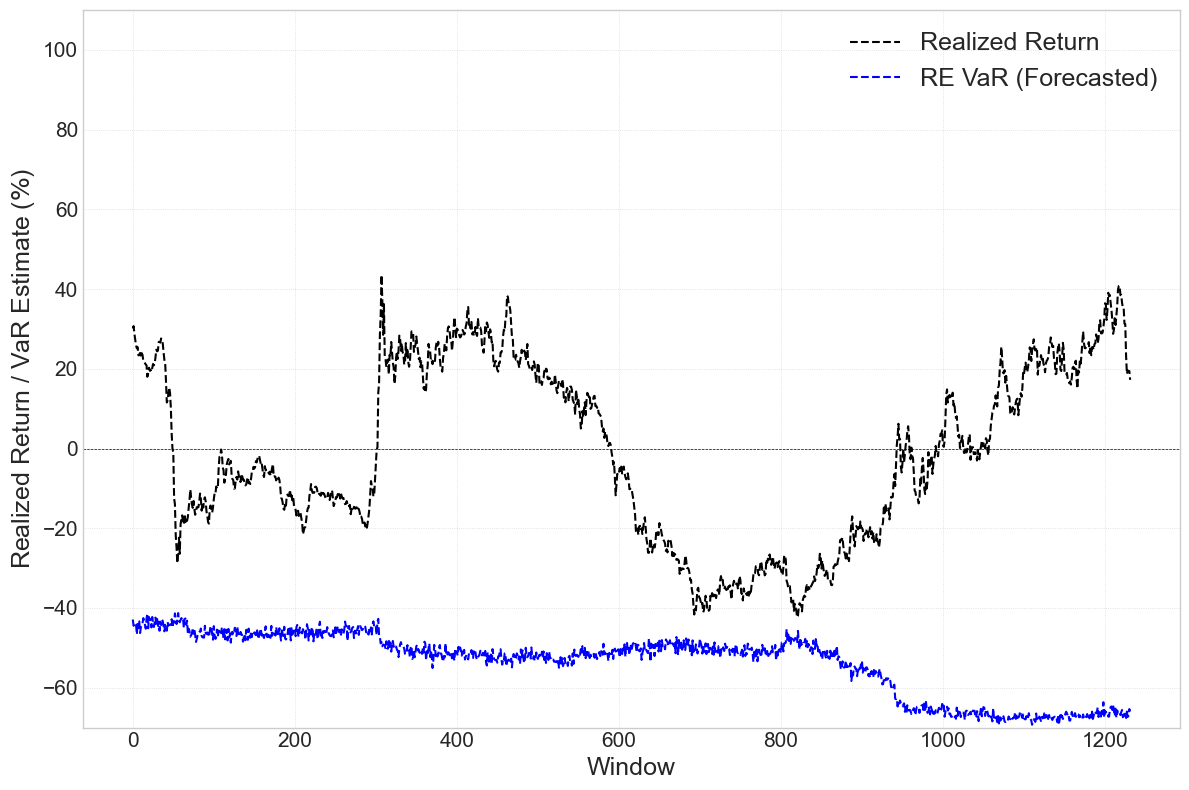

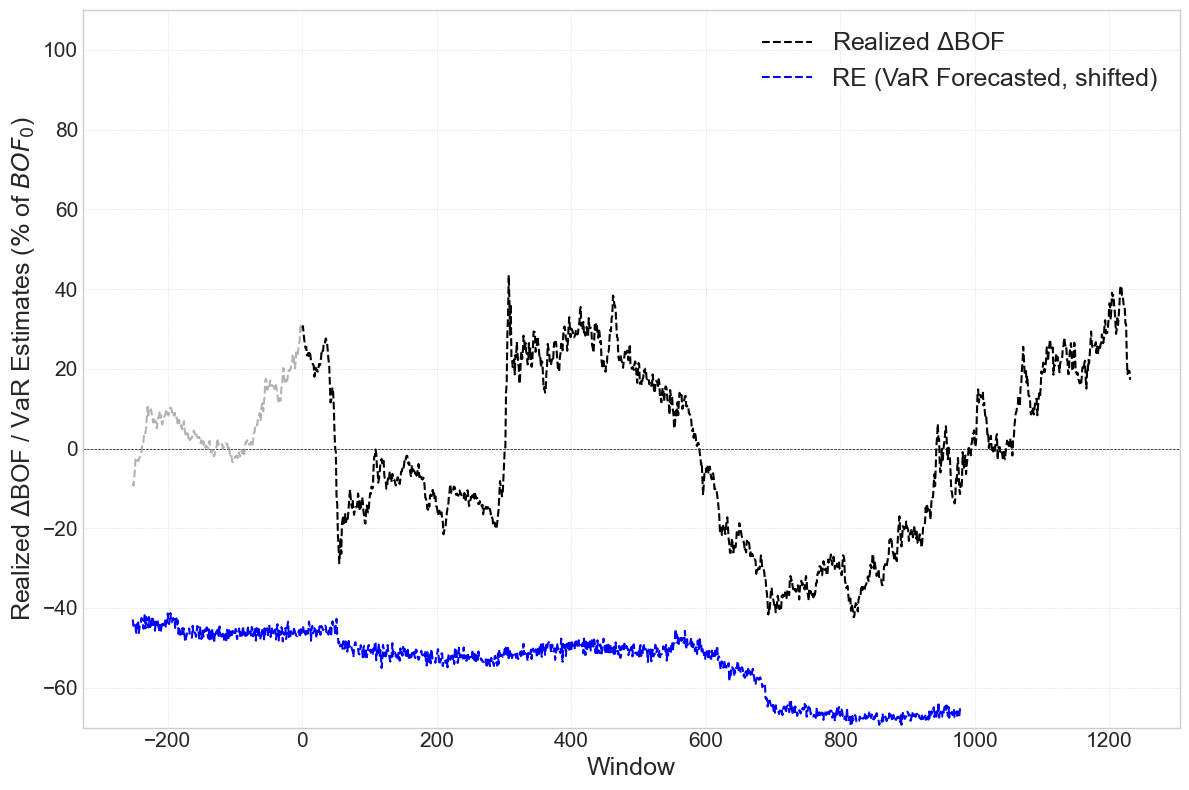

In [158]:
plot_single_forecast(
    df=reel,
    window_col='Window',
    realized_col='Realised Return',
    var_col='RE VaR (utcome-aligned)',
    label='RE VaR (Forecasted)'
)

plot_shifted(
    shifted['RE'],
    df1=reel,
    df2=reel,
    name='RE',
    col='RE VaR (utcome-aligned)',  
)

### GB

In [159]:
gb = pd.read_csv('GB.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
gb = unpack_and_explode_column(gb, 'SCR')
gb.rename(columns={'SCR': 'GB VaR (utcome-aligned)'}, inplace=True)
gb.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
gb = gb.reset_index().rename(columns={'index': 'Window'})
gb['GB VaR (utcome-aligned)'] = ((gb['GB VaR (utcome-aligned)'] -
                                    1000000) / 1000000) * 100
gb['Realised Return'] = ((gb['Realised Return'] - 1000000) / 1000000) * 100
gb.head()

,Window,GB VaR (utcome-aligned),Realised Return
0,0,-5.07,6.28
1,1,-4.54,6.84
2,2,-4.72,7.56
3,3,-4.59,7.70
4,4,-4.75,7.70


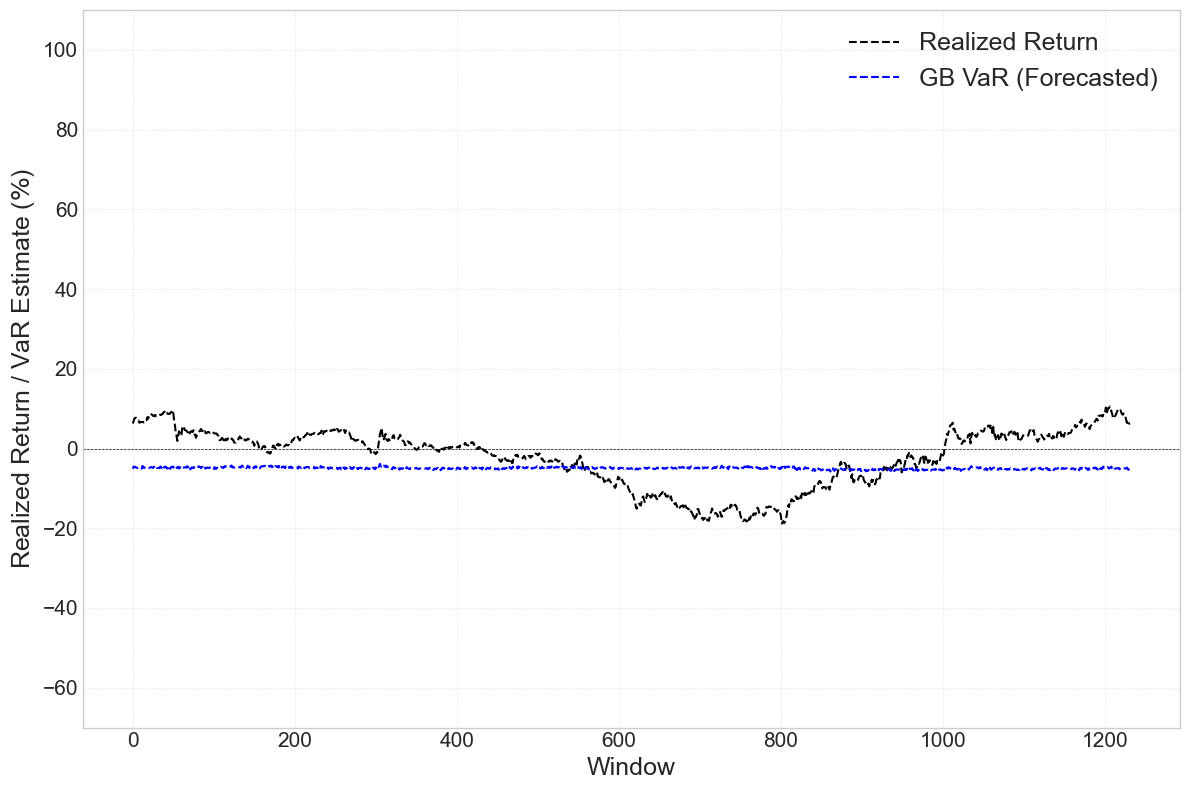

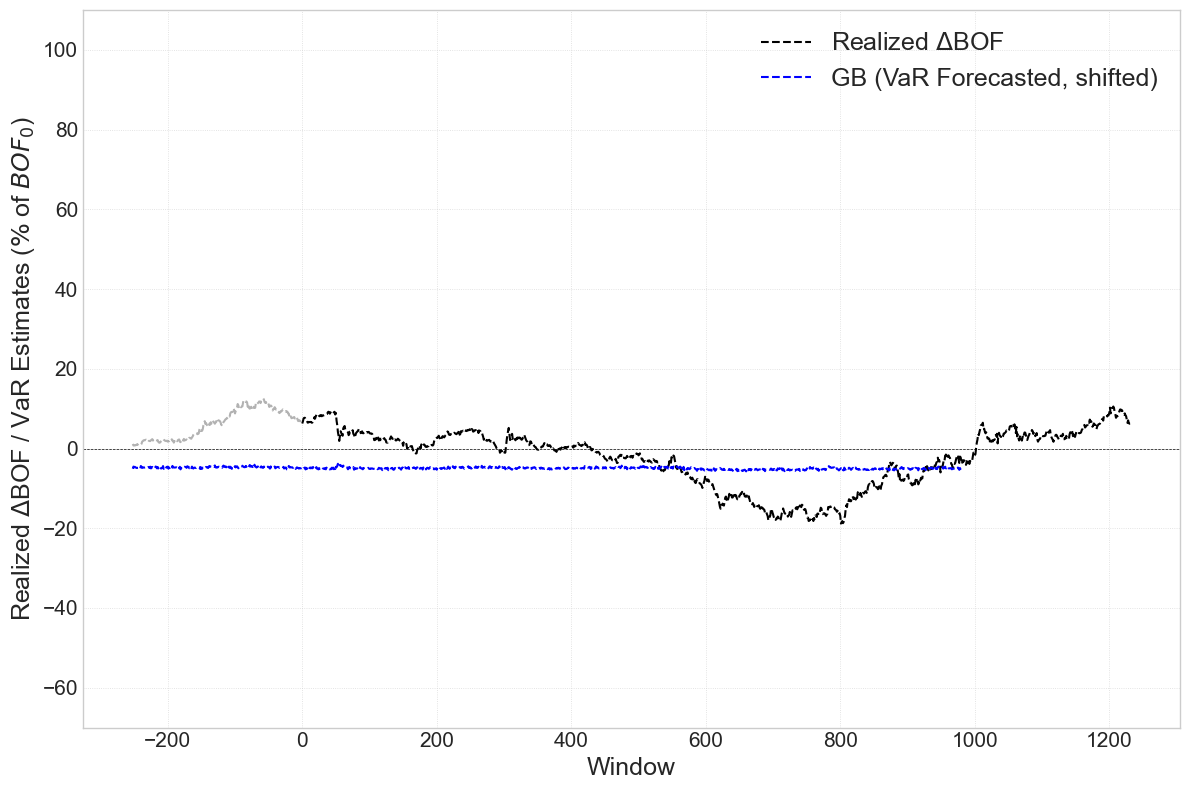

In [160]:
plot_single_forecast(
    df=gb,
    window_col='Window',
    realized_col='Realised Return',
    var_col='GB VaR (utcome-aligned)',
    label='GB VaR (Forecasted)'
)

plot_shifted(
    shifted['GB'],
    df1=gb,
    df2=gb,
    name='GB',
    col='GB VaR (utcome-aligned)',  
)


### IG CB

In [161]:
ig_cb = pd.read_csv('IG CB.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
ig_cb = unpack_and_explode_column(ig_cb, 'SCR')
ig_cb.rename(columns={'SCR': 'IG CB VaR (utcome-aligned)'}, inplace=True)
ig_cb.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
ig_cb = ig_cb.reset_index().rename(columns={'index': 'Window'})
ig_cb['IG CB VaR (utcome-aligned)'] = ((ig_cb['IG CB VaR (utcome-aligned)'] -
                                  1000000) / 1000000) * 100
ig_cb['Realised Return'] = (
    (ig_cb['Realised Return'] - 1000000) / 1000000) * 100
ig_cb.head()

,Window,IG CB VaR (utcome-aligned),Realised Return
0,0,-19.07,10.97
1,1,-17.31,10.85
2,2,-19.71,11.82
3,3,-18.66,11.62
4,4,-18.54,11.55


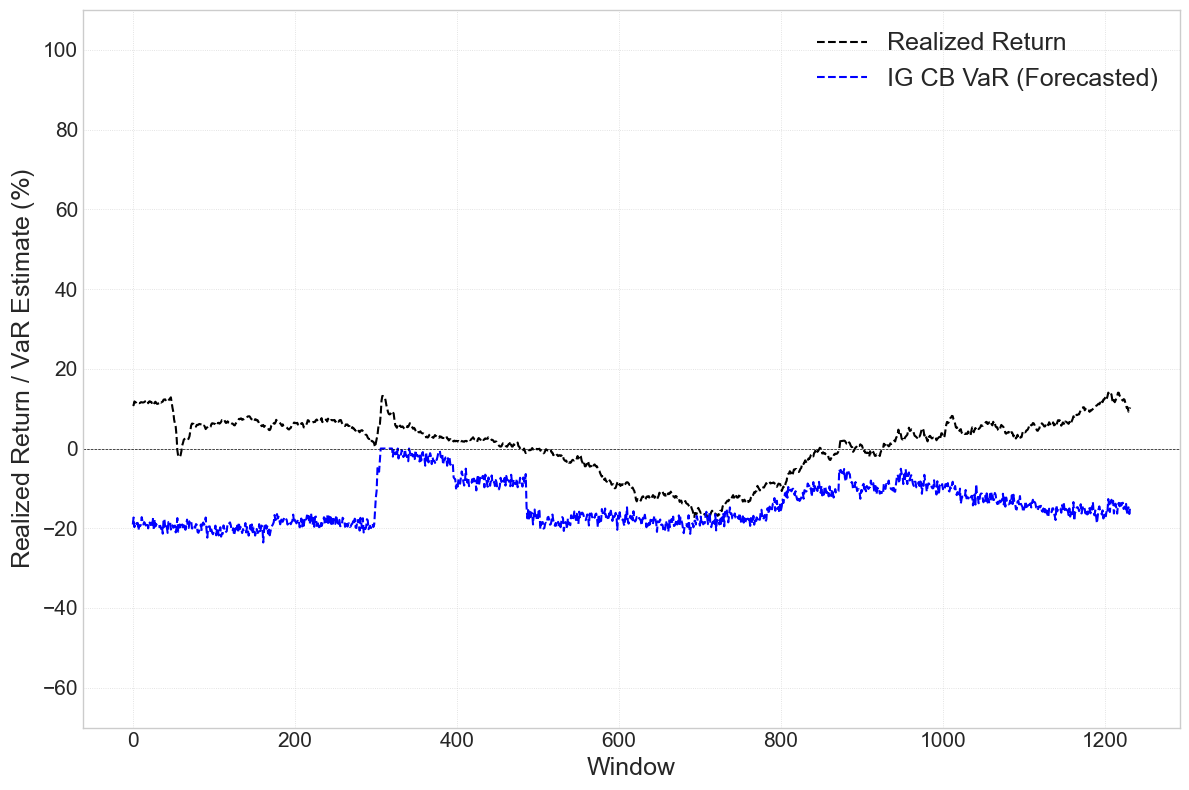

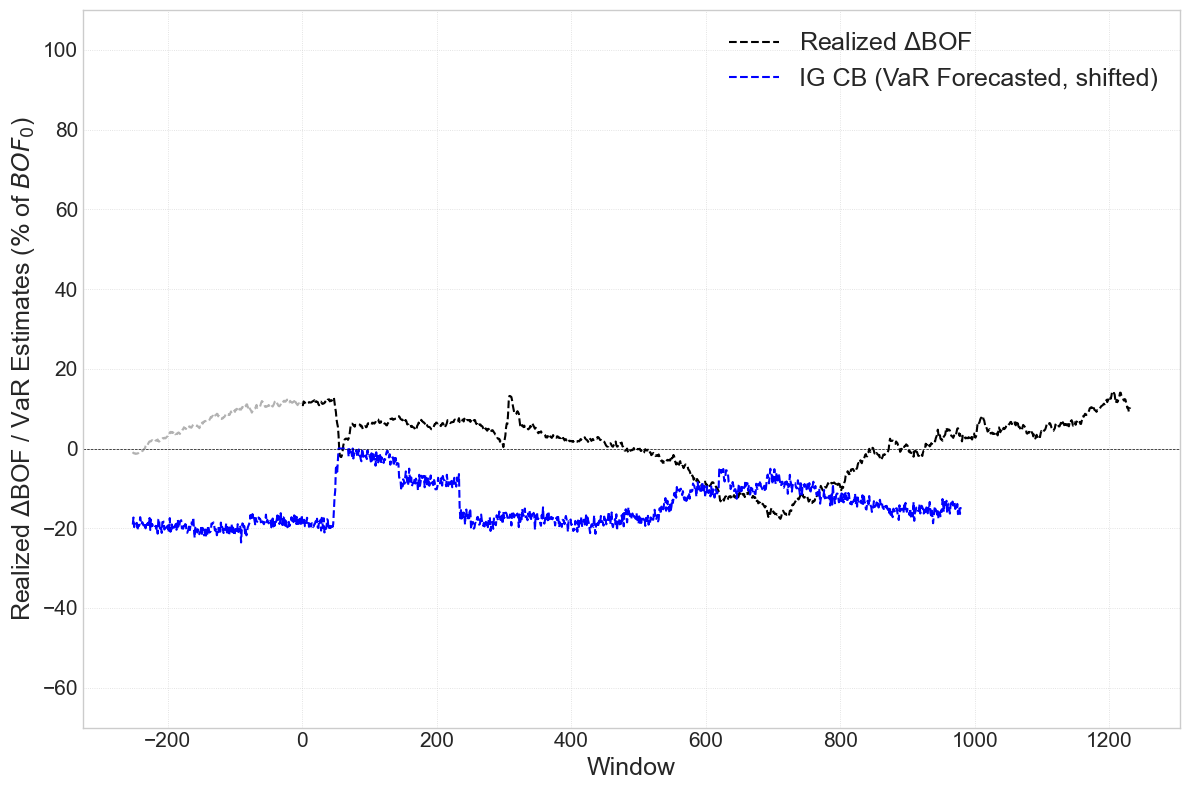

In [162]:
plot_single_forecast(
    df=ig_cb,
    window_col='Window',
    realized_col='Realised Return',
    var_col='IG CB VaR (utcome-aligned)',
    label='IG CB VaR (Forecasted)'
)

plot_shifted(
    shifted['IG CB'],
    df1=ig_cb,
    df2=ig_cb,
    name='IG CB',
    col='IG CB VaR (utcome-aligned)',  
)

### HY CB

In [163]:
hy_cb = pd.read_csv('HY CB.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
hy_cb = unpack_and_explode_column(hy_cb, 'SCR')
hy_cb.rename(columns={'SCR': 'HY CB VaR (utcome-aligned)'}, inplace=True)
hy_cb.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
hy_cb = hy_cb.reset_index().rename(columns={'index': 'Window'})
hy_cb['HY CB VaR (utcome-aligned)'] = ((hy_cb['HY CB VaR (utcome-aligned)'] -
                                        1000000) / 1000000) * 100
hy_cb['Realised Return'] = (
    (hy_cb['Realised Return'] - 1000000) / 1000000) * 100
hy_cb.head()

,Window,HY CB VaR (utcome-aligned),Realised Return
0,0,-28.62,14.00
1,1,-26.78,14.13
2,2,-26.36,13.43
3,3,-26.74,12.82
4,4,-27.27,12.42


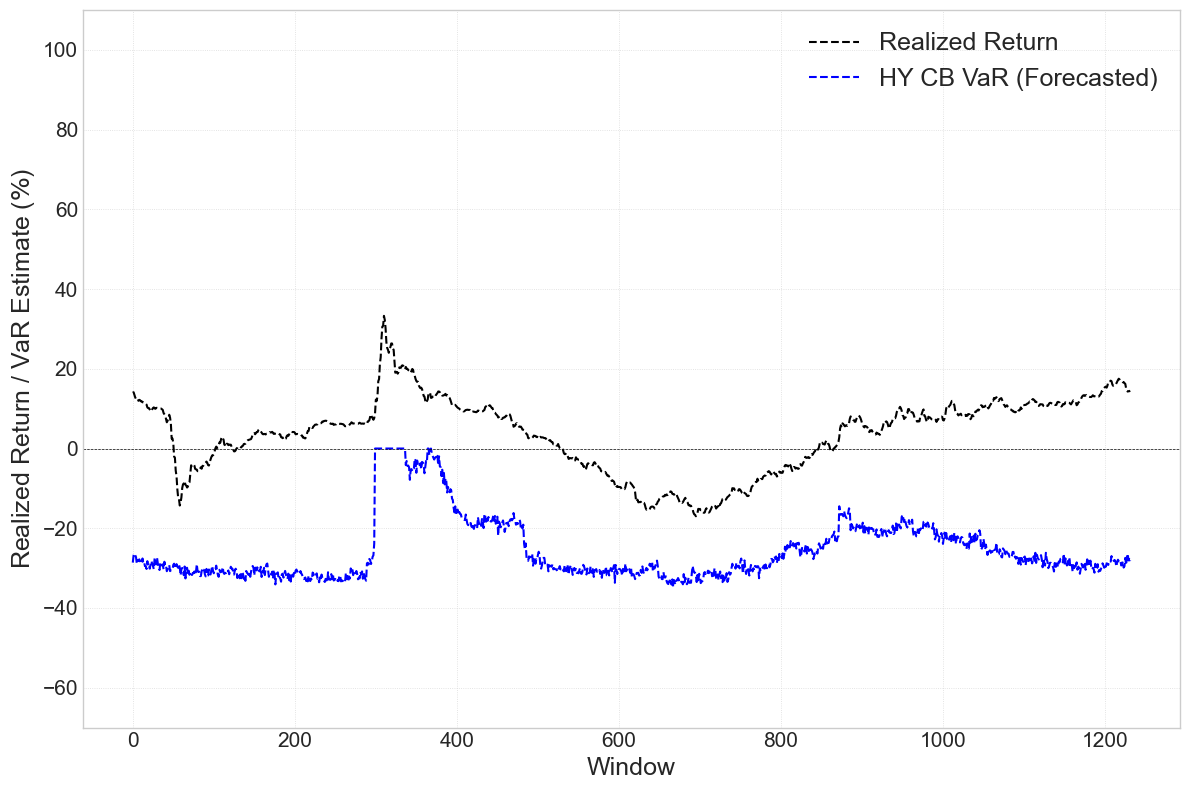

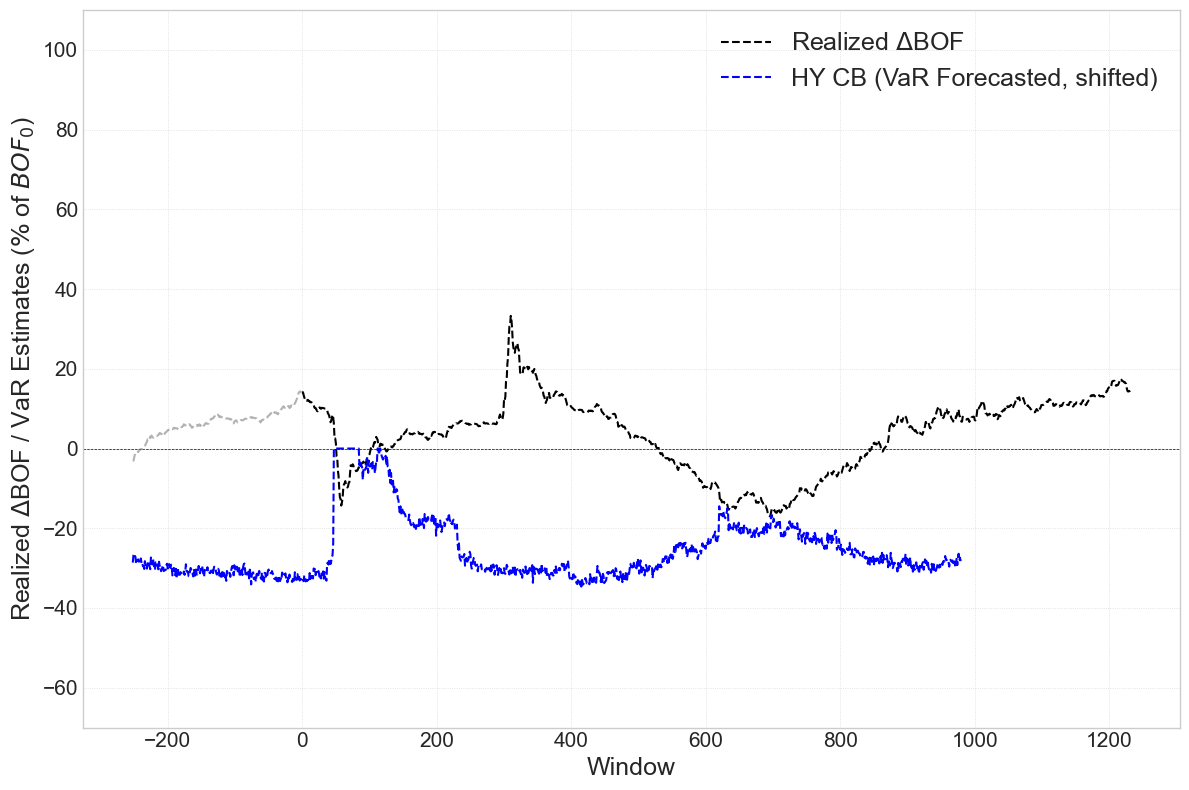

In [164]:
plot_single_forecast(
    df=hy_cb,
    window_col='Window',
    realized_col='Realised Return',
    var_col='HY CB VaR (utcome-aligned)',
    label='HY CB VaR (Forecasted)'
)

plot_shifted(
    shifted['HY CB'],
    df1=hy_cb,
    df2=hy_cb,
    name='HY CB',
    col='HY CB VaR (utcome-aligned)',  
)

### Money

In [165]:
money = pd.read_csv('Money.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
money = unpack_and_explode_column(money, 'SCR')
money.rename(columns={'SCR': 'Money VaR (utcome-aligned)'}, inplace=True)
money.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
money = money.reset_index().rename(columns={'index': 'Window'})
money['Money VaR (utcome-aligned)'] = ((money['Money VaR (utcome-aligned)'] -
                                        1000000) / 1000000) * 100
money['Realised Return'] = (
    (money['Realised Return'] - 1000000) / 1000000) * 100
money.head()

,Window,Money VaR (utcome-aligned),Realised Return
0,0,-0.16,-0.40
1,1,-0.13,-0.40
2,2,-0.15,-0.41
3,3,-0.19,-0.41
4,4,-0.19,-0.41


In [166]:
shifted.head()

,EQ,PE,RE,IG CB,HY CB,GB,MONEY
0,-5.76,-11.03,-8.60,-1.30,-3.05,1.15,-0.36
1,-7.98,-12.75,-9.30,-1.03,-3.06,0.76,-0.35
2,-6.14,-10.71,-7.66,-1.24,-2.37,0.81,-0.35
3,-5.41,-9.22,-5.63,-1.24,-1.60,0.75,-0.36
4,-4.36,-8.10,-2.77,-1.35,-1.25,0.86,-0.36


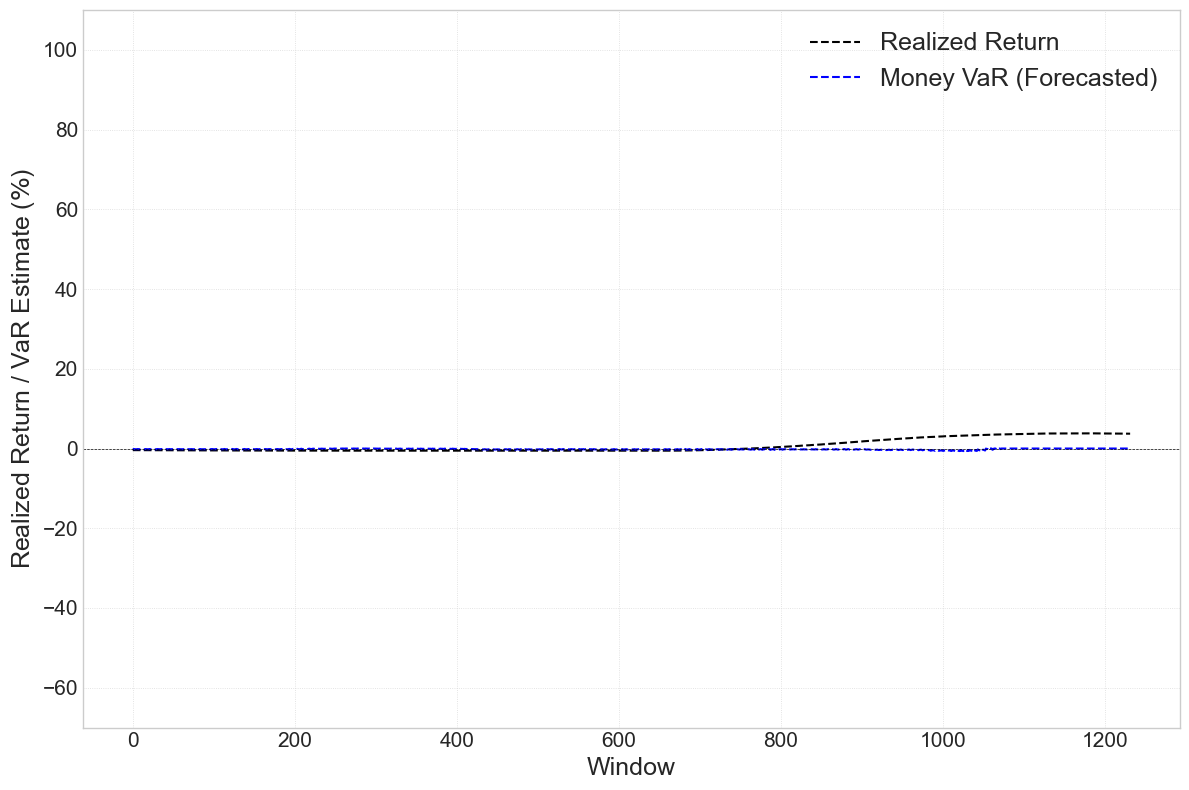

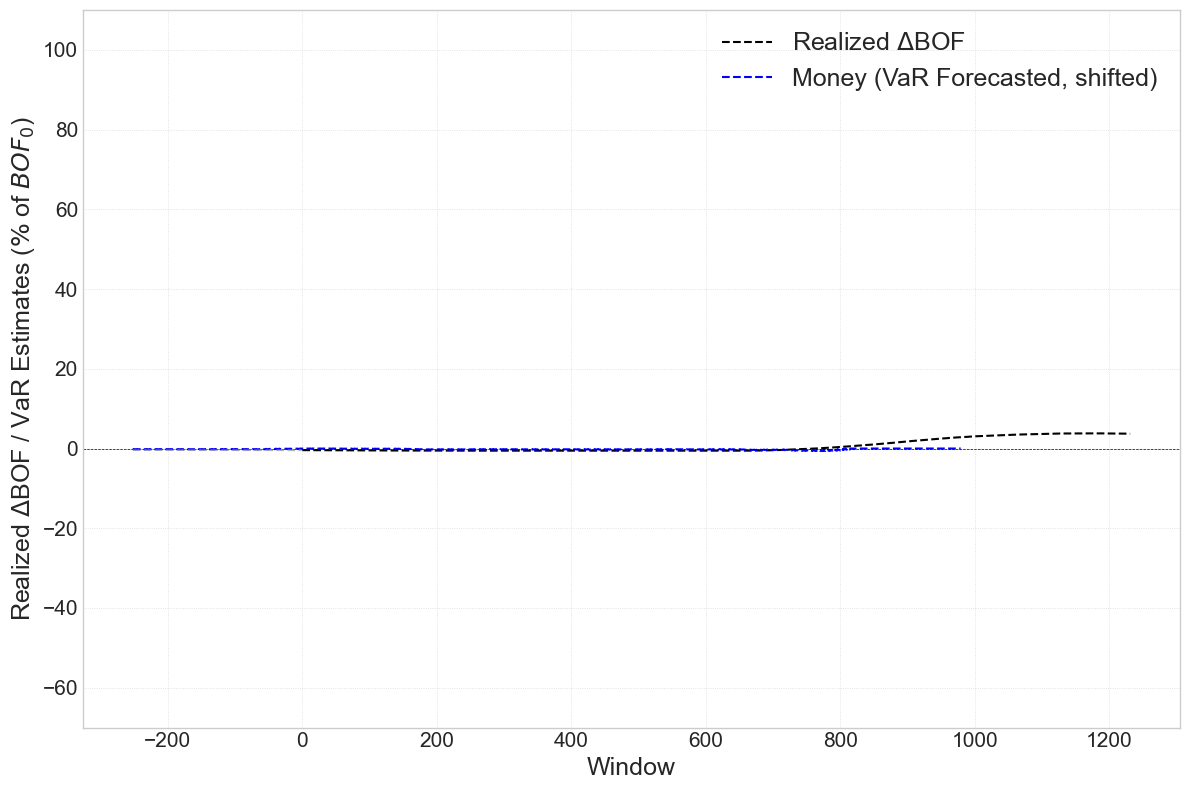

In [167]:
plot_single_forecast(
    df=money,
    window_col='Window',
    realized_col='Realised Return',
    var_col='Money VaR (utcome-aligned)',
    label='Money VaR (Forecasted)'
)

plot_shifted(
    shifted['MONEY'],
    df1=money,
    df2=money,
    name='Money',
    col='Money VaR (utcome-aligned)',  
)